## <font color='navy'> Study of Cross Correlation of Time Series - </font>

### 1) Import US High Yield and SP500 data since 2008 from Fred

In [17]:
from pandas_datareader.data import DataReader
from datetime import date

start = date(2008, 1, 1)
series = ['BAMLHYH0A0HYM2TRIV', 'SP500']
data_source = "fred"
data = DataReader(series, data_source, start)
data = data.rename(columns = {"BAMLHYH0A0HYM2TRIV":"US_HY"})

### 2) Explore the data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002183BC64208>,
      dtype=object)

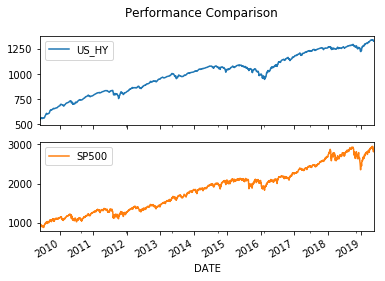

In [25]:
data.plot(subplots=True, title='Performance Comparison')

In [26]:
data.describe()

,US_HY,SP500
count,2515.000000,2515.000000
mean,1002.300170,1842.277435
std,198.001748,566.791184
min,538.230000,879.130000
25%,833.640000,1319.465000
50%,1028.900000,1880.050000
75%,1158.745000,2190.615000
max,1344.070000,2945.830000


In [27]:
data.corr()

,US_HY,SP500
US_HY,1.000000,0.973005
SP500,0.973005,1.000000


#### Comment: Looks like there is high correlation between the high yield and equity.  But it's largely due to trends.

### 3) Remove trend

In [22]:
import pandas as pd
data_new = pd.DataFrame()
data_new['return_US_HY'] = data["US_HY"].pct_change()
data_new['return_SP500'] = data["SP500"].pct_change()
auto_US_HY = data_new['return_US_HY'].autocorr()
auto_SP500 = data_new['return_SP500'].autocorr()
print("The autocorrelation of US HY daily returns is %4.2f" %(auto_US_HY))
print("The autocorrelation of SP500 daily returns is %4.2f" %(auto_SP500))

The autocorrelation of US HY daily returns is 0.42
The autocorrelation of SP500 daily returns is -0.04


### 3) Remove null value

In [28]:
data_new.info()
data_new.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2009-05-26 to 2019-05-23
Data columns (total 2 columns):
return_US_HY    2514 non-null float64
return_SP500    2514 non-null float64
dtypes: float64(2)
memory usage: 58.9 KB


### 4) Check stationarity using Augmented Dickey–Fuller test

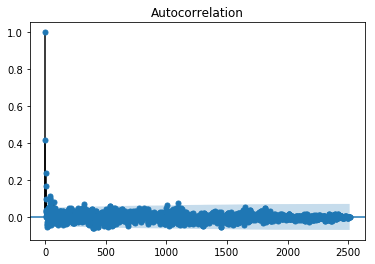

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import acf
import matplotlib.pyplot as plt
plot_acf(data_new['return_US_HY'], alpha=0.05)
plt.show()

In [41]:
from statsmodels.tsa.stattools import adfuller
adftest = adfuller(data_new['return_US_HY'])
print('The p-value of the ADF test for US HY return is: ' + str(adftest[1]))

The p-value of the test is: 5.089485083735606e-28


#### The p-value is so small that we can reject the null and conclude that the US HY return series is stationary.
#### Now we repeat the same to SP500 returns.

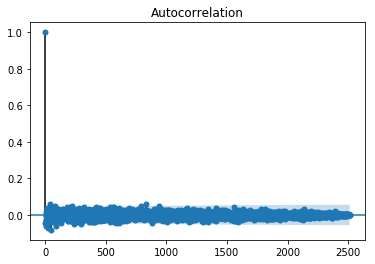

The p-value of the ADF test for SP500 return is: 1.2125837315782695e-20


In [42]:
plot_acf(data_new['return_SP500'], alpha=0.05)
plt.show()
adftest = adfuller(data_new['return_SP500'])
print('The p-value of the ADF test for SP500 return is: ' + str(adftest[1]))

#### SP500 return series is also stationary.  We can implement the correlation check on them.

### 5) Check the autocorrelation and cross correlation of the series with their past 5 days

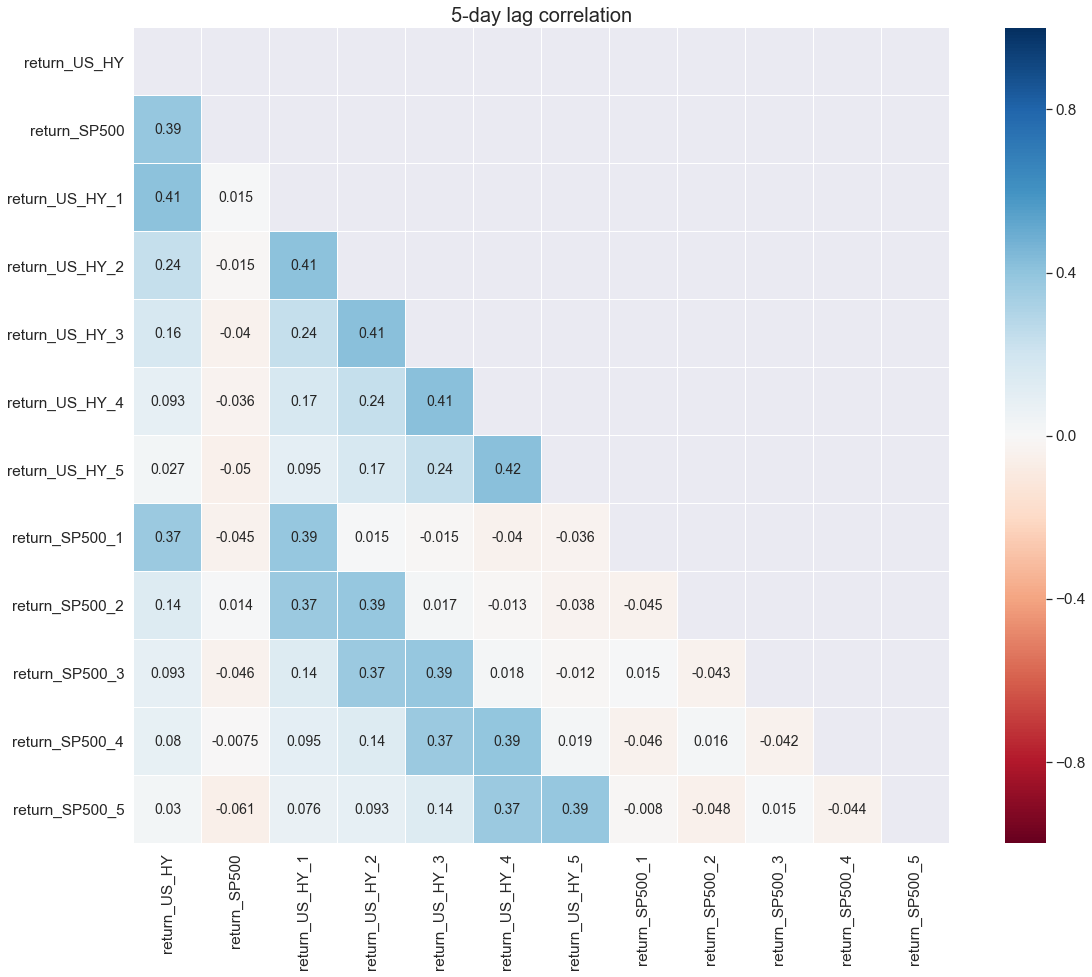

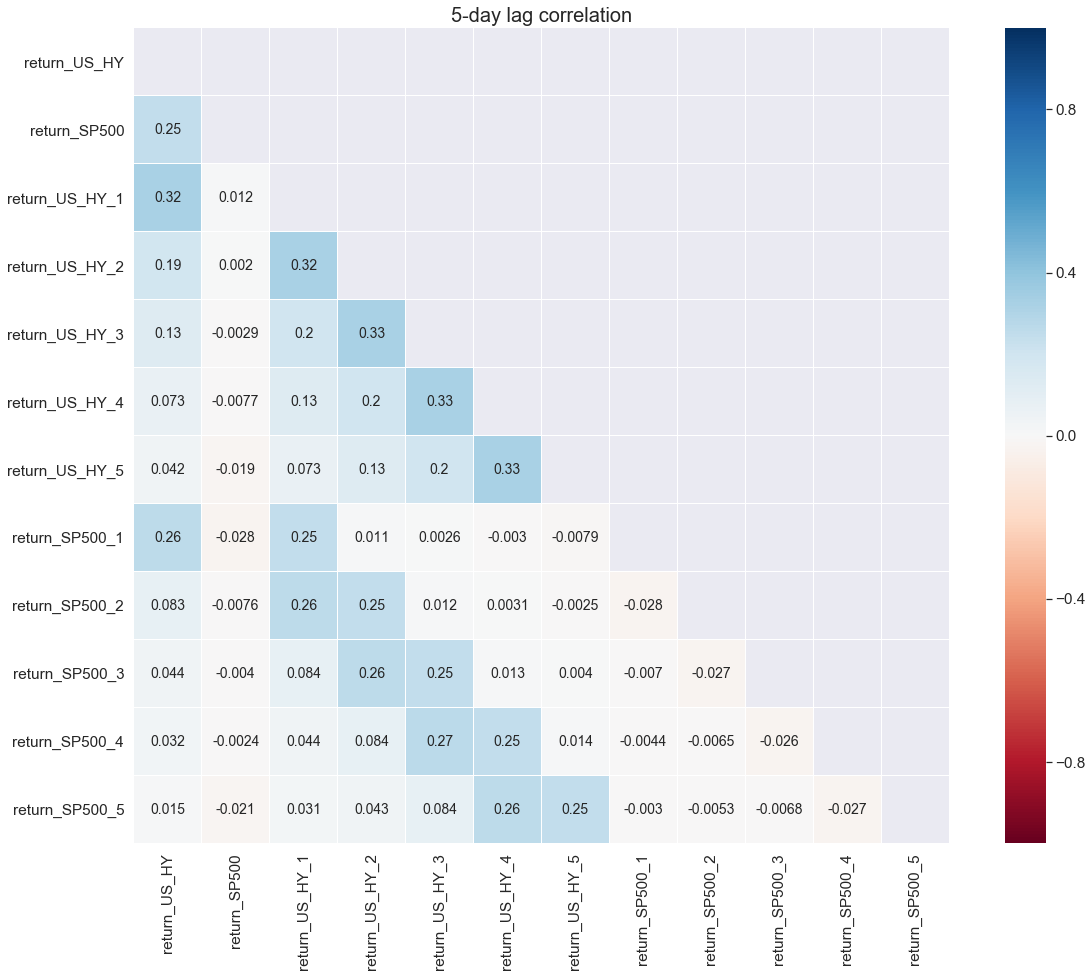

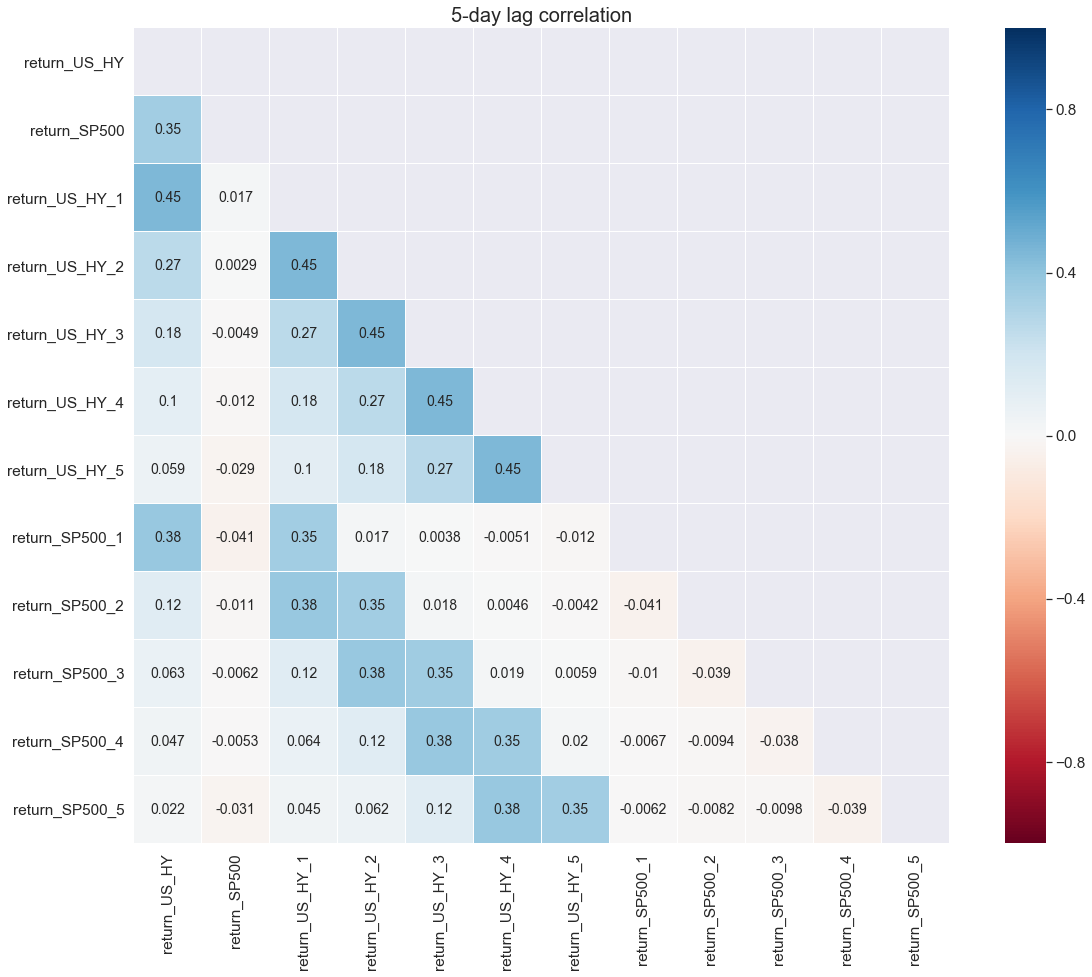

In [43]:
def df_derived_by_shift(df,lag=0,exclude=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in exclude:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df

days = 5
exclude = []
data_shift = df_derived_by_shift(data_new, days, exclude)
data_shift = data_shift.dropna()

import numpy as np
import seaborn as sns

def heatmap_corr(df, method):
    colormap = plt.cm.RdBu
    sns.set(font_scale=1.4)
    plt.figure(figsize=(20,15))
    plt.title(u'5-day lag correlation', size=20)
    mask = np.zeros_like(df.corr(method =method))
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(df.corr(method =method), mask=mask, 
                linewidths=0.1,vmax=1.0, vmin=-1.0, square=True, 
                cmap=colormap, linecolor='white', annot=True, 
                annot_kws={"size": 14})
    
heatmap_corr(data_shift, method = 'pearson')
heatmap_corr(data_shift, method = 'kendall')
heatmap_corr(data_shift, method = 'spearman')

#### None of the three correlation tests had shown meaningful autocorrelation and cross correlation of the series.  
#### If there is high correlation, we will need to verify the significance of it.